In [1]:
import os
import random
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, ZeroPadding2D
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.metrics import AUC
from sklearn.metrics import roc_auc_score, roc_curve, auc
from matplotlib.colors import LinearSegmentedColormap
from termcolor import colored

# Set seed for reproducibility of results
seed_value = 0
os.environ['PYTHONHASHSEED']=str(seed_value)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

tf.compat.v1.reset_default_graph()

random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)

# Configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

tf.__version__

'2.3.0'

In [2]:
#import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("physical_devices-------------", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

physical_devices------------- 1


In [4]:
mount_path = 'D:/'
competition_path = 'MAFAT DATA'


In [5]:
# Functions for loading the data
def load_data(file_path):
  """
  Reads all data files (metadata and signal matrix data) as python dictionary,
  the pkl and csv files must have the same file name.

  Arguments:
    file_path -- {str} -- path to the iq_matrix file and metadata file

  Returns:
    Python dictionary
  """
  pkl = load_pkl_data(file_path)
  meta = load_csv_metadata(file_path)
  data_dictionary = {**meta, **pkl}
  
  for key in data_dictionary.keys():
    data_dictionary[key] = np.array(data_dictionary[key])

  return data_dictionary


def load_pkl_data(file_path):
  """
  Reads pickle file as a python dictionary (only Signal data).

  Arguments:
    file_path -- {str} -- path to pickle iq_matrix file

  Returns:
    Python dictionary
  """
  path = os.path.join(mount_path, competition_path, file_path + '.pkl')
  with open(path, 'rb') as data:
    output = pickle.load(data)
  return output


def load_csv_metadata(file_path):
  """
  Reads csv as pandas DataFrame (only Metadata).

  Arguments:
    file_path -- {str} -- path to csv metadata file

  Returns:
    Pandas DataFarme
  """
  path = os.path.join(mount_path, competition_path, file_path + '.csv')
  with open(path, 'rb') as data:
    output = pd.read_csv(data)
  return output

In [7]:
# Functions for preprocessing and preprocess function
def fft(iq, axis=0):
  """
  Computes the log of discrete Fourier Transform (DFT).
     
  Arguments:
    iq_burst -- {ndarray} -- 'iq_sweep_burst' array
    axis -- {int} -- axis to perform fft in (Default = 0)

  Returns:
    log of DFT on iq_burst array
  """
  iq = np.log(np.abs(np.fft.fft(hann(iq), axis=axis)))
  return iq


def hann(iq, window=None):
    """
    Preformes Hann smoothing of 'iq_sweep_burst'.

    Arguments:
      iq {ndarray} -- 'iq_sweep_burst' array
      window -{range} -- range of hann window indices (Default=None)
               if None the whole column is taken

    Returns:
      Regulazied iq in shape - (window[1] - window[0] - 2, iq.shape[1])
    """
    if window is None:
        window = [0, len(iq)]

    N = window[1] - window[0] - 1
    n = np.arange(window[0], window[1])
    n = n.reshape(len(n), 1)
    hannCol = 0.5 * (1 - np.cos(2 * np.pi * (n / N)))
    return (hannCol * iq[window[0]:window[1]])[1:-1]


def max_value_on_doppler(iq, doppler_burst):
  """
  Set max value on I/Q matrix using doppler burst vector. 
     
  Arguments:
    iq_burst -- {ndarray} -- 'iq_sweep_burst' array
    doppler_burst -- {ndarray} -- 'doppler_burst' array (center of mass)
               
  Returns:
    I/Q matrix with the max value instead of the original values
    The doppler burst marks the matrix values to change by max value
  """
  iq_max_value = np.max(iq)
  for i in range(iq.shape[1]):
    if doppler_burst[i]>=len(iq):
       continue
    iq[doppler_burst[i], i] = iq_max_value
  return iq


def normalize(iq):
  """
  Calculates normalized values for iq_sweep_burst matrix:
  (vlaue-mean)/std.
  """
  m = iq.mean()
  s = iq.std()
  return (iq-m)/s


def data_preprocess(data):
  """
  Preforms data preprocessing.
  Change target_type lables from string to integer:
  'human'  --> 1
  'animal' --> 0

  Arguments:
    data -- {ndarray} -- the data set

  Returns:
    processed data (max values by doppler burst, DFT, normalization)
  """
  X=[]
  for i in range(len(data['iq_sweep_burst'])):
    iq = fft(data['iq_sweep_burst'][i])
    iq = max_value_on_doppler(iq,data['doppler_burst'][i])
    iq = normalize(iq)
    X.append(iq)

  data['iq_sweep_burst'] = np.array(X)
  if 'target_type' in data:
    data['target_type'][data['target_type'] == 'animal'] = 0
    data['target_type'][data['target_type'] == 'human'] = 1
  return data

In [8]:
# Function for splitting the data to training and validation
# and function for selecting samples of segments from the Auxiliary dataset
def split_train_val(data):
  """
  Split the data to train and validation set.
  The validation set is built from training set segments of 
  geolocation_id 1 and 4. 
  Use the function only after the training set is complete and preprocessed. 

  Arguments:
    data -- {ndarray} -- the data set to split

  Returns:
    iq_sweep_burst ndarray matrices
    target_type vector 
    for training and validation sets
  """
  idx = ((data['geolocation_id'] == 4) | (data['geolocation_id'] == 1))\
   & (data['segment_id'] % 6 == 0)
  training_x = data['iq_sweep_burst'][np.logical_not(idx)]
  training_y = data['target_type'][np.logical_not(idx)]
  validation_x = data['iq_sweep_burst'][idx]
  validation_y = data['target_type'][idx]
  return training_x, training_y, validation_x, validation_y

def aux_split(data):
  """
  Selects segments from the auxilary set for training set.
  Takes the first 3 segments (or less) from each track.

  Arguments:
    data {dataframe} -- the auxilary data

  Returns:
    The auxilary data for the training
  """
  idx = np.bool_(np.zeros(len(data['track_id'])))
  for track in np.unique(data['track_id']):
    idx |= data['segment_id']==(data['segment_id'][data['track_id'] == track][:3])
  
  for key in data:
    data[key] = data[key][idx]
  return data

In [48]:
def create_model(input_shape, init):
  """
  CNN model.

  Arguments:
    input_shape -- the shape of our input
    init -- the weight initialization

  Returns:
    CNN model    
  """
  model = Sequential()
  model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', kernel_initializer = init, bias_regularizer='l2', input_shape=input_shape,padding = "same"))
  model.add(MaxPooling2D(pool_size=(2, 2),padding = "same"))
  model.add(Dropout(0.5))
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer = init, bias_regularizer='l2',padding = "same"))
  model.add(MaxPooling2D(pool_size=(2, 2),padding = "same"))
  model.add(Dropout(0.5))
  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_initializer = init, bias_regularizer='l2',padding = "same"))
  model.add(MaxPooling2D(pool_size=(1, 1),padding = "same"))
  model.add(Dropout(0.7))
  model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_initializer = init, bias_regularizer='l2',padding = "same"))
  model.add(MaxPooling2D(pool_size=(2, 2),padding = "same"))
  model.add(Dropout(0.7))
  model.add(Flatten())
  model.add(Dense(128, kernel_regularizer = 'l2', activation='relu', kernel_initializer = init))
  model.add(Dense(64, kernel_regularizer = 'l2', activation='relu', kernel_initializer = init))
  model.add(Dense(32, kernel_regularizer = 'l2', activation='relu', kernel_initializer = init))
  model.add(Dense(32, kernel_regularizer = 'l2', activation='relu', kernel_initializer = init))

  model.add(Dense(1, activation='sigmoid', kernel_initializer = init))
  return model

In [49]:
# Function for calculating the final ROC-AUC score and plot the ROC curve,
# used in the "Results" section
def stats(pred, actual):
  """
  Computes the model ROC-AUC score and plots the ROC curve.

  Arguments:
    pred -- {ndarray} -- model's probability predictions
    actual -- the true lables

  Returns:
    ROC curve graph and ROC-AUC score
  """
  plt.figure(figsize=(20, 10))
  fpr1, tpr1, _ = roc_curve(actual[0], pred[0])
  fpr2, tpr2, _ = roc_curve(actual[1], pred[1])
  roc_auc = [auc(fpr1, tpr1), auc(fpr2, tpr2)]
  lw = 2
  plt.plot(fpr1, tpr1, lw=lw, label='Training set (ROC-AUC = %0.2f)' % roc_auc[0])
  plt.plot(fpr2, tpr2, lw=lw, label='Validation set (ROC-AUC = %0.2f)' % roc_auc[1])
  plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--', label = 'Random guess')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate', fontsize=18)
  plt.ylabel('True Positive Rate', fontsize=18)
  plt.title('Training set vs. Validation set ROC curves')
  plt.legend(loc="lower right", prop = {'size': 20})
  plt.show()

In [11]:
# Loading and preparing the data

# Loading Auxiliary Experiment set - can take a few minutes
experiment_auxiliary = 'MAFAT RADAR Challenge - Auxiliary Experiment Set V2'
experiment_auxiliary_df = load_data(experiment_auxiliary)

In [12]:
# Taking sample from the Auxiliary Experiment set
train_aux = aux_split(experiment_auxiliary_df)

C:\Users\shanm\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [13]:
# The function append_dict is for concatenating the training set 
# with the Auxiliary data set segments

def append_dict(dict1, dict2):
  for key in dict1:
    dict1[key] = np.concatenate([dict1[key], dict2[key]], axis=0)
  return dict1

In [14]:
# Training set
train_path = 'MAFAT RADAR Challenge - Training Set V1'
training_df = load_data(train_path)

# Adding segments from the experiment auxiliary set to the training set
train_df = append_dict(training_df, train_aux)

# Preprocessing and split the data to training and validation
train_df = data_preprocess(train_df.copy())
train_x, train_y, val_x, val_y = split_train_val(train_df)

val_y =  val_y.astype(int)
train_y =train_y.astype(int)
train_x = train_x.reshape(list(train_x.shape)+[1])
val_x = val_x.reshape(list(val_x.shape)+[1])

In [15]:
# Public test set - loading and preprocessing
test_path = 'MAFAT RADAR Challenge - Public Test Set V1'
test_df = load_data(test_path)
test_df = data_preprocess(test_df.copy())
test_x = test_df['iq_sweep_burst']
test_x = test_x.reshape(list(test_x.shape)+[1])

In [50]:
# Model configuration:
batch_size = 16
img_width, img_height = 126, 32
loss_function = BinaryCrossentropy()
no_epochs = 45
optimizer = Adam(learning_rate = 0.001)
input_shape = (img_width, img_height, 1)

init = tf.keras.initializers.GlorotNormal(seed = 0)

# Creating and running the model
model = create_model(input_shape, init)  
model.compile(loss=loss_function, optimizer=optimizer, metrics=[AUC(), 'accuracy'])


In [51]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 126, 32, 16)       160       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 63, 16, 16)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 63, 16, 16)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 63, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 32, 8, 32)         0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 32, 8, 32)         0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 32, 8, 64)        

In [52]:
# Model fit
history = model.fit(train_x, train_y, batch_size = batch_size, epochs = no_epochs, 
                    validation_data = (val_x, val_y))

Epoch 1/45
411/411 [==============================] - 3s 8ms/step - loss: 1.0690 - auc_7: 0.8231 - accuracy: 0.8621 - val_loss: 0.7530 - val_auc_7: 0.8012 - val_accuracy: 0.7540
Epoch 2/45
411/411 [==============================] - 3s 7ms/step - loss: 0.3577 - auc_7: 0.9178 - accuracy: 0.8988 - val_loss: 0.6142 - val_auc_7: 0.8248 - val_accuracy: 0.7573
Epoch 3/45
411/411 [==============================] - 3s 7ms/step - loss: 0.3068 - auc_7: 0.9259 - accuracy: 0.8980 - val_loss: 0.5954 - val_auc_7: 0.8517 - val_accuracy: 0.7799
Epoch 4/45
411/411 [==============================] - 3s 7ms/step - loss: 0.2778 - auc_7: 0.9309 - accuracy: 0.9067 - val_loss: 0.5554 - val_auc_7: 0.8499 - val_accuracy: 0.7832
Epoch 5/45
411/411 [==============================] - 3s 7ms/step - loss: 0.2618 - auc_7: 0.9379 - accuracy: 0.9126 - val_loss: 0.5471 - val_auc_7: 0.8508 - val_accuracy: 0.7638
Epoch 6/45
411/411 [==============================] - 3s 7ms/step - loss: 0.2509 - auc_7: 0.9426 - accuracy: 0

In [53]:
# Model fit
history = model.fit(train_x, train_y, batch_size = batch_size, epochs = 10, 
                    validation_data = (val_x, val_y))

Epoch 1/10
411/411 [==============================] - 3s 8ms/step - loss: 0.1641 - auc_7: 0.9723 - accuracy: 0.9505 - val_loss: 0.4046 - val_auc_7: 0.9264 - val_accuracy: 0.8317
Epoch 2/10
411/411 [==============================] - 3s 7ms/step - loss: 0.1618 - auc_7: 0.9730 - accuracy: 0.9511 - val_loss: 0.3492 - val_auc_7: 0.9374 - val_accuracy: 0.8803
Epoch 3/10
411/411 [==============================] - 3s 8ms/step - loss: 0.1558 - auc_7: 0.9730 - accuracy: 0.9563 - val_loss: 0.3736 - val_auc_7: 0.9426 - val_accuracy: 0.8511
Epoch 4/10
411/411 [==============================] - 3s 7ms/step - loss: 0.1592 - auc_7: 0.9742 - accuracy: 0.9511 - val_loss: 0.4443 - val_auc_7: 0.9158 - val_accuracy: 0.8220
Epoch 5/10
411/411 [==============================] - 3s 7ms/step - loss: 0.1573 - auc_7: 0.9765 - accuracy: 0.9513 - val_loss: 0.3300 - val_auc_7: 0.9477 - val_accuracy: 0.8867
Epoch 6/10
411/411 [==============================] - 3s 8ms/step - loss: 0.1578 - auc_7: 0.9759 - accuracy: 0

In [55]:
# Model fit
history = model.fit(train_x, train_y, batch_size = batch_size, epochs = 10, 
                    validation_data = (val_x, val_y))

Epoch 1/10
411/411 [==============================] - 3s 8ms/step - loss: 0.1483 - auc_7: 0.9811 - accuracy: 0.9569 - val_loss: 0.4099 - val_auc_7: 0.9353 - val_accuracy: 0.8414
Epoch 2/10
411/411 [==============================] - 3s 7ms/step - loss: 0.1573 - auc_7: 0.9746 - accuracy: 0.9516 - val_loss: 0.3620 - val_auc_7: 0.9411 - val_accuracy: 0.8544
Epoch 3/10
411/411 [==============================] - 3s 7ms/step - loss: 0.1463 - auc_7: 0.9801 - accuracy: 0.9572 - val_loss: 0.3828 - val_auc_7: 0.9415 - val_accuracy: 0.8350
Epoch 4/10
411/411 [==============================] - 3s 7ms/step - loss: 0.1530 - auc_7: 0.9770 - accuracy: 0.9562 - val_loss: 0.4138 - val_auc_7: 0.9347 - val_accuracy: 0.8479
Epoch 5/10
411/411 [==============================] - 3s 7ms/step - loss: 0.1506 - auc_7: 0.9785 - accuracy: 0.9539 - val_loss: 0.3402 - val_auc_7: 0.9445 - val_accuracy: 0.8932
Epoch 6/10
411/411 [==============================] - 3s 8ms/step - loss: 0.1520 - auc_7: 0.9796 - accuracy: 0

In [57]:
# Model fit
history = model.fit(train_x, train_y, batch_size = batch_size, epochs = 10, 
                    validation_data = (val_x, val_y))

Epoch 1/10
411/411 [==============================] - 3s 8ms/step - loss: 0.1441 - auc_7: 0.9780 - accuracy: 0.9601 - val_loss: 0.4180 - val_auc_7: 0.9414 - val_accuracy: 0.8317
Epoch 2/10
411/411 [==============================] - 3s 7ms/step - loss: 0.1547 - auc_7: 0.9769 - accuracy: 0.9522 - val_loss: 0.3275 - val_auc_7: 0.9531 - val_accuracy: 0.8803
Epoch 3/10
411/411 [==============================] - 3s 7ms/step - loss: 0.1441 - auc_7: 0.9819 - accuracy: 0.9577 - val_loss: 0.4616 - val_auc_7: 0.9419 - val_accuracy: 0.8123
Epoch 4/10
411/411 [==============================] - 3s 7ms/step - loss: 0.1462 - auc_7: 0.9790 - accuracy: 0.9545 - val_loss: 0.3997 - val_auc_7: 0.9465 - val_accuracy: 0.8479
Epoch 5/10
411/411 [==============================] - 3s 7ms/step - loss: 0.1425 - auc_7: 0.9819 - accuracy: 0.9598 - val_loss: 0.3211 - val_auc_7: 0.9513 - val_accuracy: 0.8964
Epoch 6/10
411/411 [==============================] - 3s 7ms/step - loss: 0.1462 - auc_7: 0.9803 - accuracy: 0

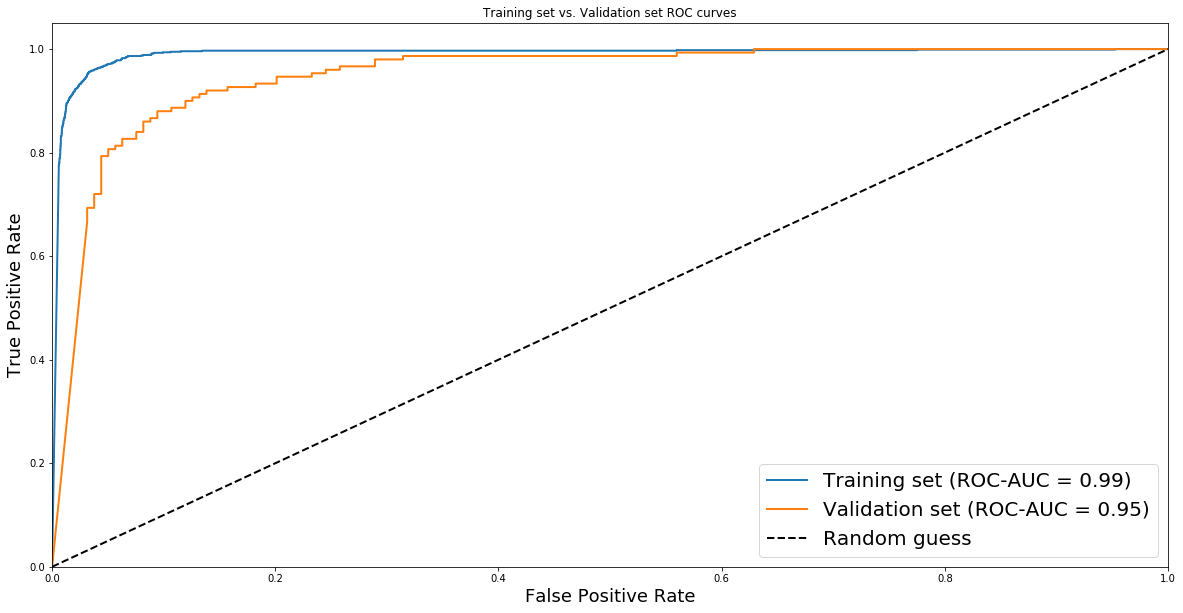

In [58]:
# Plot ROC curve and show ROC-AUC results of the training and validation sets. 
pred = [model.predict(train_x), model.predict(val_x)]
actual = [train_y, val_y]
stats(pred, actual)

In [59]:
# Creating DataFrame with the probability prediction for each segment
submission =  pd.DataFrame()
submission['segment_id'] = test_df['segment_id']
submission['prediction'] = model.predict(test_x)
submission['prediction'] = submission['prediction'].astype('float')

# Save submission
submission.to_csv('submission.csv', index=False)

In [60]:
from zipfile import ZipFile

with ZipFile('submission.zip', 'w') as myzip:
  myzip.write('submission.csv')

